Generate both a CaSR climatological mean map and one from database winds.

Interpolation is carried out on both datasets to a common grid. 
Note: it is not recommended to use this tool over all of Canada - it takes too long and the wind interpolation especially from the observed winds will result in discrepancies. 

There are several predefined averaging areas that can be used. Or you can draw your own using a built in map function.

Liam.Buchart@nrcan-rncan.gc.ca
October 6, 2025

In [111]:
# start with a widget to choose whether we are comparing stations data or just a point location on a map
import ipywidgets as widgets
from IPython.display import display
from scipy.interpolate import griddata

import plotly.express as px
import plotly.graph_objects as go

import numpy as np
import pandas as pd
import xarray as xr
import ipywidgets as widgets
import os
import json

import cartopy.crs as ccrs
import cartopy.feature as cfeature

# load the json
with open("regions_bbox_canada.json", 'r') as f:
    regions_data = json.load(f)

region_names = [region["name"] for region in regions_data["regions"]]

In [ ]:
# two selectors for the month and year
Averaging_Select = widgets.Dropdown(
    options=["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "DJF", "MAM", "JJA", "SON"], 
    value="7",
    description='Period:',
    )

Year_Select = widgets.Dropdown(
    options=np.arange(2022, 2025+1),
    value=2025,
    description='Year:',
    )

Region_Select = widgets.Dropdown(
    options=region_names,
    value="Prairies",
    description="Region:"
)

Interp_Select = widgets.Dropdown(
    options=["Cubic", "Linear", "Nearest"],
    value="Linear",
    description="Interpolation Method:"
)

print("When selecting interpolation method...")
print("Cubis is nicer but not great over the larger bounding boxes, defauly to Linear")
display(Averaging_Select, Year_Select, Region_Select, Interp_Select)

Dropdown(description='Period:', index=6, options=('1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12…

Dropdown(description='Year:', index=3, options=(np.int64(2022), np.int64(2023), np.int64(2024), np.int64(2025)…

Dropdown(description='Region:', index=1, options=('British Columbia', 'Prairies', 'Ontario', 'Quebec', 'Atlant…

Dropdown(description='Interpolation Method:', index=1, options=('Cubic', 'Linear', 'Nearest'), value='Linear')

In [103]:
# define the grid depending on the Region_Select dropdown
selected_region = Region_Select.value
bounds = next(region["bbox"] for region in regions_data["regions"] if region["name"] == selected_region)

min_lon = bounds["west"] 
max_lon = bounds["east"] # convert to the casr longitude coordinate

min_lat = bounds["south"]
max_lat = bounds["north"]

xi = np.arange(min_lon, max_lon, 0.1)
yi = np.arange(min_lat, max_lat, 0.1)

xi, yi = np.meshgrid(xi, yi)

print("Comparison Grid is Ready...")

Comparison Grid is Ready...


In [104]:
# climatological CaSR grid which is saved in 
def sort_files(dir, Astr):
    all_files = os.listdir(dir)

    day_files = [file for file in all_files if f"{str(Astr)}.h5" in file]

    return day_files

# hacky means of determining if this is a seasonal or monthly average
if Averaging_Select.value.isalpha():
    data_dir = "../climatology/seasonal/"
    p_file = sort_files(data_dir, Averaging_Select.value)

    # load the json
    with open("regions_bbox_canada.json", 'r') as f:
        season_data = json.load(f)

    months = next(season["months"] for season in season_data["seasons"] if season["name"] == Averaging_Select.value)
    mstart = months["mstart"]
    mend = months["mend"]

    sfile = f"1990-2020_seasonal_windspeed_stats_{Averaging_Select.value}.nc"
    dfile = f"1990-2020_seasonal_winddirection_stats_{Averaging_Select.value}.nc"
    
elif Averaging_Select.value.isdigit():
    data_dir = "../climatology/monthly"
    mstr = f"{int(Averaging_Select.value):02d}"
    p_file = sort_files(data_dir, mstr)

    # save some query variables
    mstart = mstr
    mend = mstr

    sfile = f"1990-2020_monthly_windspeed_stats_m{mstr}.nc"
    dfile = f"1990-2020_monthly_winddirection_stats_m{mstr}.nc"

else:
    data_dir = "Something has gone wrong"

# extract the monthly or seasonal file
casr_speed = xr.open_dataset(f"{data_dir}/{sfile}")
casr_direction = xr.open_dataset(f"{data_dir}/{dfile}")

# drop down with all the variables from the files (just need to grab one)
all_vars = list(casr_speed.keys())
Variable_Select = widgets.Dropdown(
    options=all_vars,
    value="mean",
    description="Plot Var:"
)

display(Variable_Select)

Dropdown(description='Plot Var:', options=('mean', 'median', 'std', 'p10', 'p25', 'p75', 'p90', 'p95', 'max'),…

rows after removing NaNs: 233531


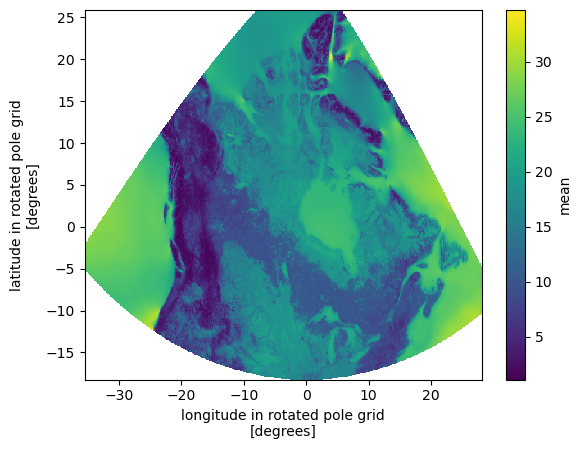

In [105]:
# quick plot of the mean wind speed using xarray's built in plotter
casr_speed[str(Variable_Select.value)].plot()

# process the casr data so it can be regridded
casr_dir = casr_direction[str(Variable_Select.value)]  #.sel(rlat=slice(min_lat, max_lat), rlon=slice(min_lon, max_lon)) 
casr_spd = casr_speed[str(Variable_Select.value)]  #.sel(rlat=slice(min_lat, max_lat), rlon=slice(min_lon, max_lon))

# also get the standard deviations for both speed and direction if needed later
casr_dir_std = casr_direction["std"].values.ravel()
casr_spd_std = casr_speed["std"].values.ravel()

lons = casr_dir["lon"].values.ravel()
lats = casr_dir["lat"].values.ravel()
dirs = casr_dir.values.ravel()
speeds = casr_spd.values.ravel()

casr_dictionary = {"lons": lons-360, 
                   "lats": lats, 
                   "dir": dirs, 
                   "speed": speeds,
                   "dir_std": casr_dir_std,
                   "spd_std": casr_spd_std}
casr_df = pd.DataFrame(casr_dictionary)

valid = np.isfinite(casr_df[["lons","lats","speed"]]).all(axis=1)
casr_df = casr_df[valid].reset_index(drop=True)
print("rows after removing NaNs:", len(casr_df))

# remove all values outside the bounding box
casr_df = casr_df[casr_df["lats"] > min_lat]
casr_df = casr_df[casr_df["lats"] < max_lat]

casr_df = casr_df[casr_df["lons"] > min_lon]
casr_df = casr_df[casr_df["lons"] < max_lon]

In [106]:
# query the database for all station data over our averaging period
from etl_station_data import db_query, set_areal_query, last_day_of_month
query = set_areal_query(int(mstart), int(mend), Year_Select.value, bounds)
print(f"SQL Query: {query}")
query_file = f"m{mstr}_{Region_Select.value}_query_output.csv"

# execute the query on dagan
db_query(query, csv_output=f"./output/{query_file}")

SELECT cwfis_allstn2025.aes, rep_date, lat, lon, elev, ws, wg, wdir FROM cwfis_allstn2025, can_hly2020s WHERE cwfis_allstn2025.aes in (SELECT aes FROM cwfis_allstn2025 WHERE lon BETWEEN -114.1 AND -96.0 AND lat BETWEEN 49.0 AND 60.0) AND rep_date BETWEEN '2025-05-01 00:00:00' AND '2025-05-31 23:00:00' AND cwfis_allstn2025.aes = can_hly2020s.aes ORDER BY rep_date, cwfis_allstn2025.aes;
SQL Query: SELECT cwfis_allstn2025.aes, rep_date, lat, lon, elev, ws, wg, wdir FROM cwfis_allstn2025, can_hly2020s WHERE cwfis_allstn2025.aes in (SELECT aes FROM cwfis_allstn2025 WHERE lon BETWEEN -114.1 AND -96.0 AND lat BETWEEN 49.0 AND 60.0) AND rep_date BETWEEN '2025-05-01 00:00:00' AND '2025-05-31 23:00:00' AND cwfis_allstn2025.aes = can_hly2020s.aes ORDER BY rep_date, cwfis_allstn2025.aes;
SSH tunnel established
('s-edm-genii', 50737)
Connecting to database cwfis as user fire
Query results saved to ./output/m05_Prairies_query_output.csv


         aes    date       lon      lat         ws        wdir
0    3010010  2025-0 -112.9654  54.2773  13.143175  179.245125
1    3010162  2025-0 -111.7787  52.3154  16.446003  192.935484
2    3010237  2025-0 -112.2783  53.9176  16.770168  183.285714
3    3010730  2025-0 -110.1011  52.1242  16.947972  190.900699
4    3010992  2025-0   -110.51  52.3343  17.942517  193.703497
..       ...     ...       ...      ...        ...         ...
211  5062918  2025-0  -97.8766  55.7988  13.265814  143.484522
212  5062921  2025-0   -97.867     55.8  11.551417  121.376518
213  3036099  2025-0  -113.883   50.183  16.114717  204.356604
214  5050961  2025-0  -101.683   54.683    12.9725     142.675
215  4056121  2025-0 -105.1531   52.419  14.841192  157.775068

[216 rows x 6 columns]


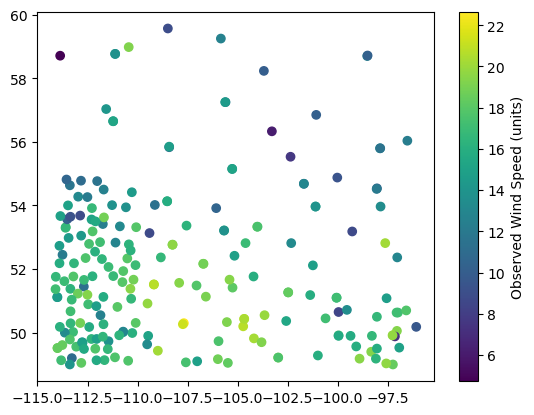

In [107]:
# open the queried file using pandas
obs_winds = pd.read_csv(f"./output/{query_file}")

# drop wg (wind gust) column 
obs_winds = obs_winds.drop(columns=["wg"], errors='ignore')

# remove all rows with NaN values
obs_winds = obs_winds.dropna()

obs_winds_means = pd.DataFrame(columns=["aes", "date", "lon", "lat", "ws", "wdir"])
aes_unique = obs_winds["aes"].unique()

# add the unique aes to the means dataframe
obs_winds_means["aes"] = aes_unique

# loop through the means dataframe and populate with the duration averages
for row, index in obs_winds_means.iterrows():
    station = index["aes"]
    station_data = obs_winds[obs_winds["aes"] == station]
    mean_date = station_data["rep_date"].iloc[0][0:6]  # assuming all dates are the same for the averaging period just the YYYY-MM
    mean_lon = station_data["lon"].mean()
    mean_lat = station_data["lat"].mean()
    mean_ws = station_data["ws"].mean()
    mean_wdir = station_data["wdir"].mean()

    obs_winds_means.at[row, "date"] = mean_date
    obs_winds_means.at[row, "lon"] = mean_lon
    obs_winds_means.at[row, "lat"] = mean_lat
    obs_winds_means.at[row, "ws"] = mean_ws
    obs_winds_means.at[row, "wdir"] = mean_wdir

print(obs_winds_means)
# contour plot of the observed wind speeds
# imshow of the wind speed interpolation
import matplotlib.pyplot as plt
plt.scatter(obs_winds_means["lon"], obs_winds_means["lat"], c=obs_winds_means["ws"], cmap='viridis')
plt.colorbar(label='Observed Wind Speed (units)')
plt.show()


In [108]:
def regrid_data(xo, yo, zo, xint, yint, method):
    # xo, yo, zo = grids of input data
    # xi, yi = grid to interpolate onto
    # method = string (linear, nearest, cubic)
    
    # convert xo, yo, zo to arrays
    xo = np.array(xo)
    yo = np.array(yo)
    zo = np.array(zo)

    return griddata((xo, yo), zo, (xint, yint), method=method)

# interpolate these winds onto the previously created grid
wsi = regrid_data(list(obs_winds_means["lon"]), list(obs_winds_means["lat"]),
                  list(obs_winds_means["ws"]),
                  xi, yi, 
                  method=Interp_Select.value.lower())

wdi = regrid_data(list(obs_winds_means["lon"]), list(obs_winds_means["lat"]),
                  list(obs_winds_means["wdir"]),
                  xi, yi, 
                  method=Interp_Select.value.lower())



In [109]:
# carry out a similar process on the casr data that has been extracted.
with open("../utils/variables.json", 'r') as f:
    casr_vars = json.load(f)

casr_wsi = regrid_data(list(casr_df["lons"]), list(casr_df["lats"]), 
                       list(casr_df["speed"]),
                       xi, yi,
                       method=Interp_Select.value.lower())

casr_wdi = regrid_data(list(casr_df["lons"]), list(casr_df["lats"]), 
                       list(casr_df["dir"]),
                       xi, yi,
                       method=Interp_Select.value.lower())

# interpolate the stds
casr_wdi_std = regrid_data(list(casr_df["lons"]), list(casr_df["lats"]), 
                       list(casr_df["dir_std"]),
                       xi, yi,
                       method=Interp_Select.value.lower())

casr_wsi_std = regrid_data(list(casr_df["lons"]), list(casr_df["lats"]), 
                       list(casr_df["spd_std"]),
                       xi, yi,
                       method=Interp_Select.value.lower())


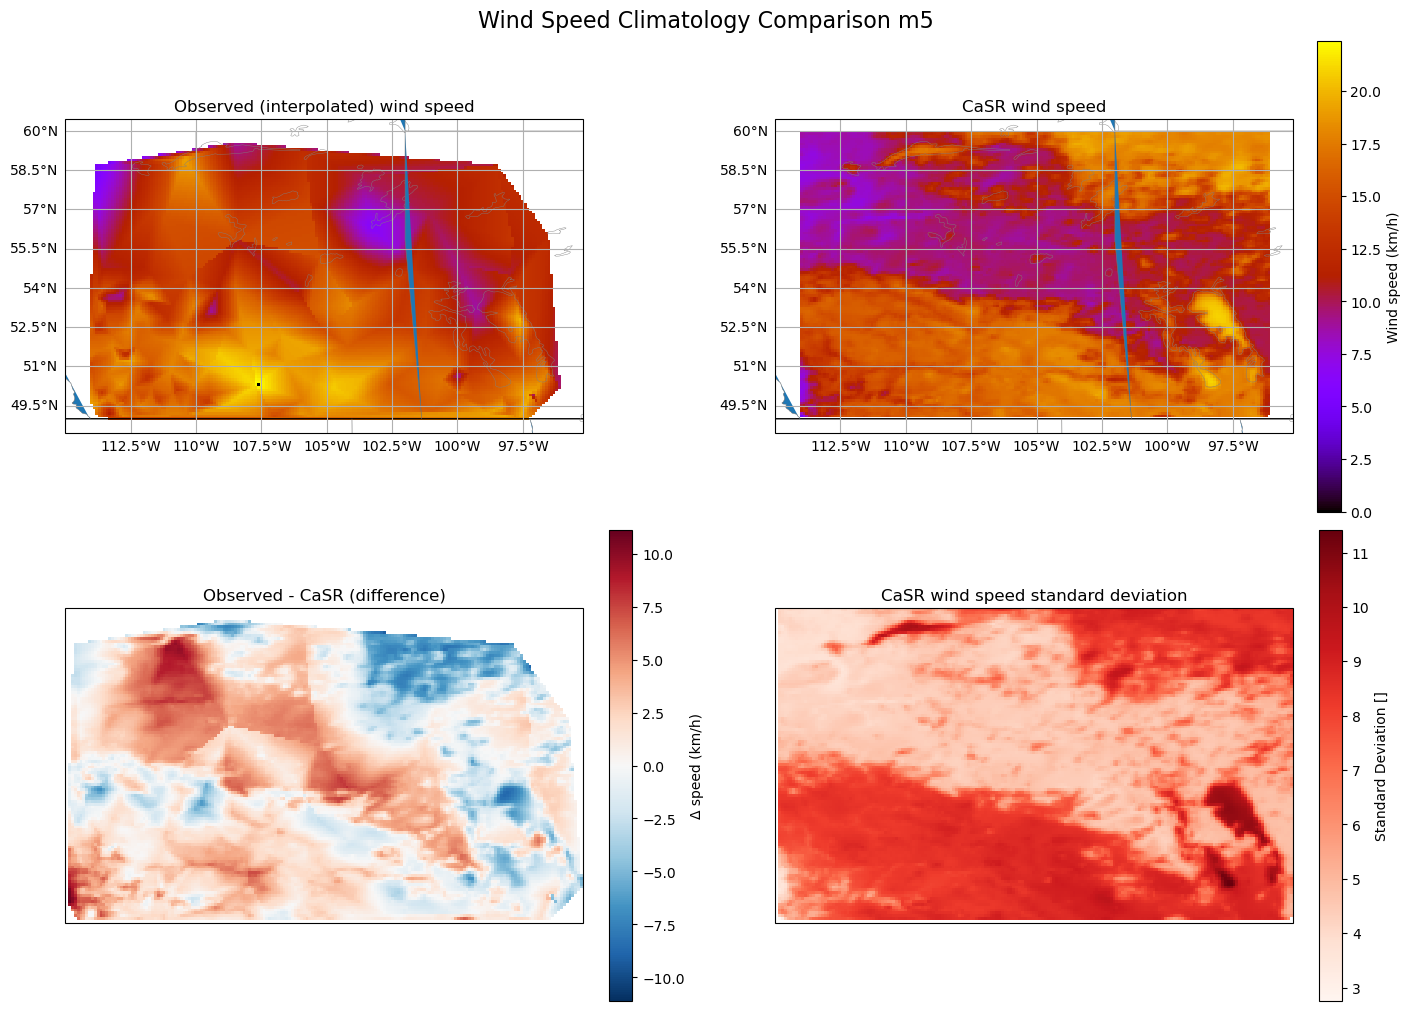

In [114]:
# matplotlib contour plots of the regridded data, difference, and standard devatation in 4 subfigures
# assumes xi, yi, wsi, casr_wsi, casr_wsi_std exist (2D arrays with same shape)

# helper to draw common map features
def prettify(ax):
    ax.set_extent(extent, crs=proj)
    ax.coastlines(resolution='50m', linewidth=1)
    ax.add_feature(cfeature.BORDERS.with_scale('50m'), linewidth=1, color='k')
    ax.add_feature(cfeature.LAKES.with_scale('50m'), facecolor='none', edgecolor='0.5', linewidth=0.3)
    # admin_1 (provinces/states) if available
    try:
        provinces = cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces_lines', '50m')
        ax.add_feature(provinces, edgecolor='0.45', linewidth=0.4)
    except Exception:
        pass
    gl = ax.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False)
    gl.top_labels = False
    gl.right_labels = False

# compute extent and small padding
lonmin, lonmax = float(np.nanmin(xi)), float(np.nanmax(xi))
latmin, latmax = float(np.nanmin(yi)), float(np.nanmax(yi))
pad_lon = 0.05 * (lonmax - lonmin) if lonmax>lonmin else 0.5
pad_lat = 0.05 * (latmax - latmin) if latmax>latmin else 0.5
extent = [lonmin - pad_lon, lonmax + pad_lon, latmin - pad_lat, latmax + pad_lat]

# mask
wsi_m = np.ma.masked_invalid(wsi)
casr_m = np.ma.masked_invalid(casr_wsi)
std_m = np.ma.masked_invalid(casr_wsi_std)
diff_m = np.ma.masked_invalid(wsi - casr_wsi)

# common color scale for observed and CaSR
valid_vals = np.hstack([arr.compressed() for arr in (wsi_m, casr_m) if arr is not None])
vmin, vmax = float(0), float(round(valid_vals.max(), 5))

# cmap
cmap = plt.colormaps["gnuplot"].with_extremes(under="white", over="black")

# symmetric range for difference
dvals = diff_m.compressed() if diff_m.mask is not None else diff_m.ravel()
if dvals.size:
    dl = max(abs(dvals.min()), abs(dvals.max()))
else:
    dl = 1.0

proj = ccrs.PlateCarree()
fig, axs = plt.subplots(2, 2, figsize=(14, 10),
                        subplot_kw=dict(projection=proj),
                        constrained_layout=True)

# Observed (interpolated)
prettify(axs[0,0])
im0 = axs[0, 0].pcolormesh(xi, yi, wsi_m, shading='auto', vmin=vmin, vmax=vmax,
                           cmap=cmap)
axs[0, 0].set_title('Observed (interpolated) wind speed')
axs[0, 0].set_xlabel('Longitude'); axs[0, 0].set_ylabel('Latitude')

# CaSR (use same color scale & colorbar as observed)
im1 = axs[0, 1].pcolormesh(xi, yi, casr_m, shading='auto', vmin=vmin, vmax=vmax,
                           cmap=cmap)
axs[0, 1].set_title('CaSR wind speed')
axs[0, 1].set_xlabel('Longitude'); axs[0, 1].set_ylabel('Latitude')
prettify(axs[0,1])

# Difference
im2 = axs[1, 0].pcolormesh(xi, yi, diff_m, cmap='RdBu_r', shading='auto', vmin=-dl, vmax=dl)
axs[1, 0].set_title('Observed - CaSR (difference)')
axs[1, 0].set_xlabel('Longitude'); axs[1, 0].set_ylabel('Latitude')

# CaSR std dev
im3 = axs[1, 1].pcolormesh(xi, yi, std_m, cmap='Reds', shading='auto')
axs[1, 1].set_title('CaSR wind speed standard deviation')
axs[1, 1].set_xlabel('Longitude'); axs[1, 1].set_ylabel('Latitude')

# Shared colorbar for observed & CaSR (top row)
cbar_shared = fig.colorbar(im0, ax=[axs[0,0], axs[0,1]], orientation='vertical', fraction=0.05, pad=0.02)
cbar_shared.set_label('Wind speed (km/h)')

# Separate colorbars for diff and std
fig.colorbar(im2, ax=axs[1,0], label='Δ speed (km/h)')
fig.colorbar(im3, ax=axs[1,1], label='Standard Deviation []')
fig.suptitle(f'Wind Speed Climatology Comparison m{Averaging_Select.value}', fontsize=16)
plt.show()

In [70]:
# begin making plots of the values themselves
# Example data
latitudes = yi.flatten()
longitudes = xi.flatten()

# center & heuristic zoom to fit extent
center_lat = float(np.nanmean(latitudes))
center_lon = float(np.nanmean(longitudes))
span = max(float(np.nanmax(longitudes)-np.nanmin(longitudes)), float(np.nanmax(latitudes)-np.nanmin(latitudes)))
zoom = float(np.clip(4 + np.log2(360.0 / span), 1, 12)) if span > 0 else 4.0
print(zoom)

# couple nice dictionaries to make nice plots
plot_mapbox=dict(
    style="open-street-map",  # No token needed
    center=dict(lat=np.mean(latitudes), lon=np.mean(longitudes)),  # Center of the map
    zoom=4  # Zoom level (0 = world, 22 = building level)
    ),
plot_margin=dict(l=0, r=0, t=0, b=0)

# build figure
fig1 = go.Figure()

# CaSR semi-transparent overlay (acts like a contour/heat overlay)
fig1.add_trace(go.Scattermapbox(
    lat=latitudes,
    lon=longitudes,
    mode='markers',
    marker=dict(
        size=6,
        color=casr_wsi.flatten(),
        colorscale='Jet',
        opacity=0.55,
        colorbar=dict(title='CaSR Wind Speed [km/h]'),
    ),
    name='CaSR Wind Speed'
))
fig1.update_layout(
    title='Interpolated Winds — CaSR',
    mapbox=dict(
        style='carto-positron',
        center=dict(lat=center_lat, lon=center_lon),
        zoom=zoom
    ),
    margin=dict(l=0, r=0, t=30, b=0)
)

fig1.show()


fig = px.scatter_mapbox(
    lat=latitudes,
    lon=longitudes,
    color=casr_wsi.flatten(),
    color_continuous_scale="Jet",
    size_max=15,
    zoom=3,
    mapbox_style="carto-positron",
    title="Interpolated Observed Wind Speed [km/h] Map"
)

fig.show()


8.321928094887443


In [ ]:
# plot the difference
wsi_diff = wsi - casr_wsi

fig = px.scatter_mapbox(
    lat=latitudes,
    lon=longitudes,
    color=wsi_diff.flatten(),
    color_continuous_scale="temps",
    zoom=3,
    mapbox_style="carto-positron",
    title="Difference Between Obs and CaSR Climatology [km/h] Map"
)
fig.show()

# plot the wind speed standard deviation from casr
fig = px.scatter_mapbox(
    lat=latitudes,
    lon=longitudes,
    color=casr_wsi_std.flatten(),
    color_continuous_scale="reds",
    size_max=15,
    zoom=3,
    mapbox_style="carto-positron",
    title="CaSR Wind Speed Standard Deviation [km/h] Map"
)

fig.show()

TypeError: scatter_mapbox() got an unexpected keyword argument 'style'